In [1]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import sys
from tqdm import tqdm
from glob import glob
import json
import gc
import torch
from torch import nn
from torch.nn import functional as F
import monai

# Dataloaders

In [2]:
class Ellipsoids(torch.utils.data.Dataset):
    def __init__(self, images, radii):
        self.images = torch.FloatTensor(np.array(images))
        self.radii = torch.FloatTensor(np.array(radii))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image = self.images[index]
        radius = self.radii[index]
        return image, radius

In [3]:
image_paths = sorted(glob('../dataset/Ellipsoids/segmentations/*.nrrd'))
images = np.array([nrrd.read(path)[0][None, :] for path in image_paths])
radii = np.array([float(path.split('_')[-1][:5]) for path in image_paths])[:, None]
images.shape, radii.shape

((81, 1, 64, 64, 64), (81, 1))

In [4]:
train_size = 61
perm = np.random.RandomState(seed=0).permutation(81)
perm = {
    'train': perm[:train_size],
    'val': perm[train_size:],
}
modes = list(perm.keys())
dataloaders = dict()
for mode in modes:
    dataloaders[mode] = torch.utils.data.DataLoader(
        Ellipsoids(images[perm[mode]], radii[perm[mode]]),
        batch_size=1,
        shuffle=(mode == 'train'),
        num_workers=os.cpu_count(),
        pin_memory=torch.cuda.is_available()
    )

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_dir = '../dataset/Ellipsoids/models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Encoder Training

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(64 ** 3, 1)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

def train_encoder(model, dataloaders, num_epochs, learning_rate):
    opt = torch.optim.Adam(model.parameters(), learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.99)
    loss_mae = torch.nn.L1Loss().to(device)
    
    t0 = time.time()
    best_val_loss = np.Inf
    
    for epoch in range(1, num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            else:
                model.eval()
            
            losses = []
            for image, radius in dataloaders[mode]:
                image = image.to(device)
                radius = radius.to(device)
                
                pred_radius = model(image)
                loss = loss_mae(pred_radius, radius)
                
                if mode == 'train':
                    opt.zero_grad()
                    loss.backward()
                    opt.step()

                losses.append(loss.item())

            print(f'{mode} loss: {np.mean(losses)}')
        
        scheduler.step()

        val_loss = np.mean(losses)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), f'{model_dir}/best_encoder.torch')
        print(f'Best val loss: {best_val_loss}')

        time_elapsed = time.time() - t0
        print(f'Time: {time_elapsed}\n')
        t0 = time.time()
        
    print(f"Training complete, model saved. Best model after epoch {best_epoch}")

In [8]:
del encoder
gc.collect()
torch.cuda.empty_cache()

In [9]:
encoder = Encoder().to(device)
train_encoder(model=encoder, dataloaders=dataloaders, num_epochs=500, learning_rate=1e-6)

Epoch 1/500
train loss: 19.348507474680417
val loss: 20.410970878601074
Best val loss: 20.410970878601074
Time: 0.6211552619934082

Epoch 2/500
train loss: 18.909148231881563
val loss: 19.95078296661377
Best val loss: 19.95078296661377
Time: 0.5598747730255127

Epoch 3/500
train loss: 18.477684083532115
val loss: 19.49126214981079
Best val loss: 19.49126214981079
Time: 0.5211882591247559

Epoch 4/500
train loss: 18.048988561161227
val loss: 19.036054134368896
Best val loss: 19.036054134368896
Time: 0.5424017906188965

Epoch 5/500
train loss: 17.623235999560748
val loss: 18.593648862838744
Best val loss: 18.593648862838744
Time: 0.5795338153839111

Epoch 6/500
train loss: 17.20410074953173
val loss: 18.152721977233888
Best val loss: 18.152721977233888
Time: 0.5948479175567627

Epoch 7/500
train loss: 16.789176518799827
val loss: 17.7118718624115
Best val loss: 17.7118718624115
Time: 0.5738470554351807

Epoch 8/500
train loss: 16.375852850616955
val loss: 17.28484377861023
Best val loss:

# Decoder Training

In [29]:
model = monai.networks.nets.AutoEncoder(
    spatial_dims=3, in_channels=1, out_channels=1,
    kernel_size=(3, 3, 3),
    channels=[channel*1 for channel in (1, 2, 4, 8, 16)],
    strides=(2, 2, 2, 2, 2),
)

In [46]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(1, 16*2*2*2)
        self.decode = monai.networks.nets.AutoEncoder(
            spatial_dims=3, in_channels=1, out_channels=1,
            kernel_size=(3, 3, 3),
            channels=[channel*1 for channel in (1, 2, 4, 8, 16)],
            strides=(2, 2, 2, 2, 2),
        ).decode
        
    def forward(self, x):
        x = self.fc(x)
        x = torch.reshape(x, (1, 16, 2, 2, 2))
        x = self.decode(x)
        return x

def train_decoder(model, dataloaders, num_epochs, learning_rate):
    opt = torch.optim.Adam(model.parameters(), learning_rate)
    opt.zero_grad()
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.99)
    loss_dice = monai.losses.DiceLoss(sigmoid=True, squared_pred=True).to(device)

    metric = monai.metrics.DiceMetric(include_background=False, reduction='mean_batch')

    t0 = time.time()
    best_val_dsc = 0
    
    for epoch in range(1, num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            else:
                model.eval()
            
            losses = []
            for image, radius in dataloaders[mode]:
                image = image.to(device)
                radius = radius.to(device)
                
                pred_segm = model(radius)
                loss = loss_dice(pred_segm, image)
                
                if mode == 'train':
                    opt.zero_grad()
                    loss.backward()
                    opt.step()

                losses.append(loss.item())
                metric((pred_segm > 0).float(), image)

            print(f'{mode} loss: {np.mean(losses)}')
            mean_dsc = metric.aggregate().tolist()[0]
            metric.reset()
            print(f'{mode} DSC: {mean_dsc}')
        
        scheduler.step()

        if mean_dsc > best_val_dsc:
            best_val_dsc = mean_dsc
            best_epoch = epoch
            torch.save(model.state_dict(), f'{model_dir}/best_decoder.torch')
        print(f'Best val DSC: {best_val_dsc}')

        time_elapsed = time.time() - t0
        print(f'Time: {time_elapsed}\n')
        t0 = time.time()
        
    print(f"Training complete, model saved. Best model after epoch {best_epoch}")

In [49]:
decoder = Decoder().to(device)
train_decoder(model=decoder, dataloaders=dataloaders, num_epochs=800, learning_rate=3e-3)

Epoch 1/800
train loss: 0.8572288956798491
train DSC: 0.20258405804634094
val loss: 0.8015431195497513
val DSC: 0.6159278154373169
Best val DSC: 0.6159278154373169
Time: 1.1787209510803223

Epoch 2/800
train loss: 0.7791847879769372
train DSC: 0.6285985708236694
val loss: 0.7265393555164337
val DSC: 0.6727702021598816
Best val DSC: 0.6727702021598816
Time: 1.170889139175415

Epoch 3/800
train loss: 0.6966711057991278
train DSC: 0.682629406452179
val loss: 0.6229707896709442
val DSC: 0.7676151990890503
Best val DSC: 0.7676151990890503
Time: 1.1702656745910645

Epoch 4/800
train loss: 0.5806515656533788
train DSC: 0.7535243630409241
val loss: 0.48680145740509034
val DSC: 0.8066158294677734
Best val DSC: 0.8066158294677734
Time: 1.1696629524230957

Epoch 5/800
train loss: 0.4505528377704933
train DSC: 0.7923573851585388
val loss: 0.3618992030620575
val DSC: 0.8406642079353333
Best val DSC: 0.8406642079353333
Time: 1.1872260570526123

Epoch 6/800
train loss: 0.344969383028687
train DSC: 0.

RuntimeError: DataLoader worker (pid(s) 144588) exited unexpectedly

In [50]:
del decoder
gc.collect()
torch.cuda.empty_cache()

# Autoencoder

In [55]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.autoencoder = monai.networks.nets.AutoEncoder(
            spatial_dims=3, in_channels=1, out_channels=1,
            kernel_size=(3, 3, 3),
            channels=[channel*1 for channel in (1, 2, 4, 8, 16)],
            strides=(2, 2, 2, 2, 2),
        )
        self.fc1 = nn.Linear(16*2*2*2, 1)
        self.fc2 = nn.Linear(1, 16*2*2*2)
        
    def forward(self, x):
        x = self.autoencoder.encode(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.reshape(x, (1, 16, 2, 2, 2))
        x = self.autoencoder.decode(x)
        return x

def train_autoencoder(model, dataloaders, num_epochs, learning_rate):
    opt = torch.optim.Adam(model.parameters(), learning_rate)
    opt.zero_grad()
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.99)
    loss_dice = monai.losses.DiceLoss(sigmoid=True, squared_pred=True).to(device)

    metric = monai.metrics.DiceMetric(include_background=False, reduction='mean_batch')

    t0 = time.time()
    best_val_dsc = 0
    
    for epoch in range(1, num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            else:
                model.eval()
            
            losses = []
            for image, _ in dataloaders[mode]:
                image = image.to(device)
                
                pred_segm = model(image)
                loss = loss_dice(pred_segm, image)
                
                if mode == 'train':
                    opt.zero_grad()
                    loss.backward()
                    opt.step()

                losses.append(loss.item())
                metric((pred_segm > 0).float(), image)

            print(f'{mode} loss: {np.mean(losses)}')
            mean_dsc = metric.aggregate().tolist()[0]
            metric.reset()
            print(f'{mode} DSC: {mean_dsc}')
        
        scheduler.step()

        if mean_dsc > best_val_dsc:
            best_val_dsc = mean_dsc
            best_epoch = epoch
            torch.save(model.state_dict(), f'{model_dir}/best_antocoder.torch')
        print(f'Best val DSC: {best_val_dsc}')

        time_elapsed = time.time() - t0
        print(f'Time: {time_elapsed}\n')
        t0 = time.time()
        
    print(f"Training complete, model saved. Best model after epoch {best_epoch}")

In [56]:
autoencoder = Autoencoder().to(device)
train_autoencoder(model=autoencoder, dataloaders=dataloaders, num_epochs=800, learning_rate=3e-3)

Epoch 1/800
train loss: 0.856694152120684
train DSC: 0.22146211564540863
val loss: 0.7879289716482163
val DSC: 0.470258891582489
Best val DSC: 0.470258891582489
Time: 1.6074154376983643

Epoch 2/800
train loss: 0.742305799585874
train DSC: 0.5333993434906006
val loss: 0.6696064352989197
val DSC: 0.6439070105552673
Best val DSC: 0.6439070105552673
Time: 1.5894250869750977

Epoch 3/800
train loss: 0.6389368225316532
train DSC: 0.6664378046989441
val loss: 0.568173748254776
val DSC: 0.718650221824646
Best val DSC: 0.718650221824646
Time: 1.5681190490722656

Epoch 4/800
train loss: 0.541881118641525
train DSC: 0.7319675087928772
val loss: 0.46698082983493805
val DSC: 0.7975710034370422
Best val DSC: 0.7975710034370422
Time: 1.5989782810211182

Epoch 5/800
train loss: 0.44564765496332137
train DSC: 0.8009586930274963
val loss: 0.3700594544410706
val DSC: 0.873343288898468
Best val DSC: 0.873343288898468
Time: 1.5778107643127441

Epoch 6/800
train loss: 0.35559920991053345
train DSC: 0.86234

KeyboardInterrupt: 

In [64]:
def predict(model, dataloaders):
    model.eval()
    pred = []
    true = []
    for mode in ['train', 'val']:
        for image, radius in dataloaders[mode]:
            image = image.to(device)
            true.append(radius.item())
            pred_radius = model.fc1(torch.flatten(model.autoencoder.encode(image), start_dim=1))
            pred.append(pred_radius.item())
    return pred, true

In [65]:
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load(f'{model_dir}/best_antocoder.torch'))
pred, true = predict(model=autoencoder, dataloaders=dataloaders)

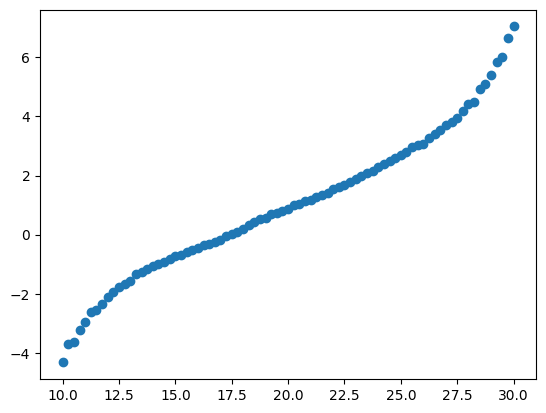

In [68]:
plt.scatter(true, pred)
plt.show()